In [1]:
#%matplotlib notebook
%matplotlib inline 
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [113]:
import csv
import os
rootdir = "kernel_size_3/"

data = []
for subdir, dirs, files in os.walk(rootdir):
    for d in dirs:
        file = os.path.join(subdir, d) + "/PM2.5_prediction.csv"
        with open(file) as csvfile:
            readCSV = csv.reader(csvfile, delimiter=" ")
            pm = []
            for row in readCSV:
                pm.append(list(map(float,row)))
            pm = np.asarray(pm)
            pm = pm.flatten()
            data.append(pm)
    break
data = np.asarray(data)
#data = data[9:]
print(data.shape)

(19, 400)


In [114]:
ave = np.average(data, axis=0)
ave = np.reshape(ave, (20,20))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1911972355629887865
]


(50, 5)

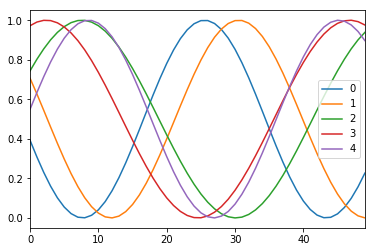

In [28]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

# New Section

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

def sample_data(n_samples=10000, x_vals=np.arange(0, 5, .1), max_offset=100, mul_range=[1, 2]):
    vectors = []
    for i in range(n_samples):
        offset = np.random.random() * max_offset
        mul = mul_range[0] + np.random.random() * (mul_range[1] - mul_range[0])
        vectors.append(
            np.sin(offset + x_vals * mul) / 2 + .5
        )
    return np.array(vectors)

ax = pd.DataFrame(np.transpose(sample_data(5))).plot()

sample_data(5).shape

pd.DataFrame(np.transpose(sample_data(5))).shape

In [115]:
#def get_generative(G_in, dense_dim=200, out_dim=50, lr=1e-3):
#def get_generative(G_in, dense_dim=200, out_dim=20, lr=1e-3):

noise = 10
samples = 19 

def get_generative(G_in, dense_dim=200, out_dim=400, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

G_in = Input(shape=[noise])
G, G_out = get_generative(G_in)
print('-------G--------')
G.summary()



def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=20, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

#D_in = Input(shape=[50])
#D_in = Input(shape=[20])
D_in = Input(shape=[400])
D, D_out = get_discriminative(D_in)
print('-------D--------')
D.summary()



def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

GAN_in = Input([noise])
GAN, GAN_out = make_gan(GAN_in, G, D)
print('-------GAN--------')
GAN.summary()


#def sample_data_and_gen(G, data,noise_dim=10, n_samples=142):
#def sample_data_and_gen(G, data,noise_dim=10, n_samples=20):
def sample_data_and_gen(G, data,noise_dim=10, n_samples=19):
    #XT = sample_data(n_samples=n_samples)
    XT = data
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    XN = G.predict(XN_noise)
    X = np.concatenate((XT, XN))
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y

#def pretrain(G, D, data,noise_dim=10, n_samples=142, batch_size=32):
#def pretrain(G, D, data,noise_dim=10, n_samples=20, batch_size=32):
def pretrain(G, D, data,noise_dim=10, n_samples=19, batch_size=32):
    X, y = sample_data_and_gen(G, data,n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size)


#def sample_noise(G, noise_dim=10, n_samples=142):
#def sample_noise(G, noise_dim=10, n_samples=20):
def sample_noise(G, noise_dim=10, n_samples=19):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y

#def train(GAN, G, D, epochs=500, n_samples=142, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
#def train(GAN, G, D, epochs=500, n_samples=20, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
def train(GAN, G, D, epochs=500, n_samples=19, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
    d_loss = []
    g_loss = []
    LG = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, data,n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        LG.append(G)
        #if verbose and (epoch + 1) % v_freq == 0:
        print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss, LG
pretrain(G, D,data, noise_dim=noise, n_samples=samples)
d_loss, g_los, LG = train(GAN, G, D, verbose=True, noise_dim=noise, n_samples=samples)

-------G--------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 10)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 200)               2200      
_________________________________________________________________
activation_11 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 400)               80400     
Total params: 82,600
Trainable params: 82,600
Non-trainable params: 0
_________________________________________________________________
-------D--------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 400)               0         
______________________________________

Epoch #1: Generative Loss: 0.854965090751648, Discriminative Loss: 0.3467254042625427
Epoch #2: Generative Loss: 1.013657569885254, Discriminative Loss: 0.29124361276626587
Epoch #3: Generative Loss: 1.220724105834961, Discriminative Loss: 0.2245016098022461
Epoch #4: Generative Loss: 1.4996076822280884, Discriminative Loss: 0.18271993100643158
Epoch #5: Generative Loss: 1.7382559776306152, Discriminative Loss: 0.13657541573047638
Epoch #6: Generative Loss: 2.0993666648864746, Discriminative Loss: 0.09396342188119888
Epoch #7: Generative Loss: 2.6145522594451904, Discriminative Loss: 0.06706617027521133
Epoch #8: Generative Loss: 2.923306941986084, Discriminative Loss: 0.04950439929962158
Epoch #9: Generative Loss: 2.963247537612915, Discriminative Loss: 0.03409783914685249
Epoch #10: Generative Loss: 3.617276668548584, Discriminative Loss: 0.022978290915489197
Epoch #11: Generative Loss: 3.816347599029541, Discriminative Loss: 0.017710616812109947
Epoch #12: Generative Loss: 4.2423658

Epoch #103: Generative Loss: 6.919070720672607, Discriminative Loss: 0.0007043663645163178
Epoch #104: Generative Loss: 6.826624870300293, Discriminative Loss: 0.0006506511126644909
Epoch #105: Generative Loss: 7.069417953491211, Discriminative Loss: 0.0007620057440362871
Epoch #106: Generative Loss: 6.8136820793151855, Discriminative Loss: 0.0006359796971082687
Epoch #107: Generative Loss: 6.966033935546875, Discriminative Loss: 0.0006974110146984458
Epoch #108: Generative Loss: 6.926446437835693, Discriminative Loss: 0.0007216057856567204
Epoch #109: Generative Loss: 6.976499080657959, Discriminative Loss: 0.0006913821562193334
Epoch #110: Generative Loss: 7.095246315002441, Discriminative Loss: 0.0006164225051179528
Epoch #111: Generative Loss: 7.0746049880981445, Discriminative Loss: 0.0005698393215425313
Epoch #112: Generative Loss: 6.9784040451049805, Discriminative Loss: 0.000567510025575757
Epoch #113: Generative Loss: 7.29296875, Discriminative Loss: 0.000612163741607219
Epoch

Epoch #202: Generative Loss: 7.150450706481934, Discriminative Loss: 0.0009653976303525269
Epoch #203: Generative Loss: 7.480434417724609, Discriminative Loss: 0.0009049836662597954
Epoch #204: Generative Loss: 7.424895286560059, Discriminative Loss: 0.001197090488858521
Epoch #205: Generative Loss: 7.580681324005127, Discriminative Loss: 0.0010291638318449259
Epoch #206: Generative Loss: 7.7541584968566895, Discriminative Loss: 0.0009998439345508814
Epoch #207: Generative Loss: 6.834990501403809, Discriminative Loss: 0.0014285583747550845
Epoch #208: Generative Loss: 7.4368815422058105, Discriminative Loss: 0.0010694281663745642
Epoch #209: Generative Loss: 7.717709064483643, Discriminative Loss: 0.001684264512732625
Epoch #210: Generative Loss: 7.604726791381836, Discriminative Loss: 0.0009060017764568329
Epoch #211: Generative Loss: 7.651322841644287, Discriminative Loss: 0.0011058662785217166
Epoch #212: Generative Loss: 7.978089332580566, Discriminative Loss: 0.0016386526403948665

Epoch #296: Generative Loss: 3.4044246673583984, Discriminative Loss: 0.16771136224269867
Epoch #297: Generative Loss: 2.5218114852905273, Discriminative Loss: 0.20354975759983063
Epoch #298: Generative Loss: 6.219089031219482, Discriminative Loss: 0.22580337524414062
Epoch #299: Generative Loss: 4.516592979431152, Discriminative Loss: 0.37927743792533875
Epoch #300: Generative Loss: 3.6277823448181152, Discriminative Loss: 0.38518384099006653
Epoch #301: Generative Loss: 3.764171838760376, Discriminative Loss: 0.27211469411849976
Epoch #302: Generative Loss: 5.132150173187256, Discriminative Loss: 0.4259735345840454
Epoch #303: Generative Loss: 4.145713806152344, Discriminative Loss: 0.3988378047943115
Epoch #304: Generative Loss: 1.9870926141738892, Discriminative Loss: 0.3986678421497345
Epoch #305: Generative Loss: 1.8028604984283447, Discriminative Loss: 0.33317258954048157
Epoch #306: Generative Loss: 2.11552357673645, Discriminative Loss: 0.4918547570705414
Epoch #307: Generativ

Epoch #391: Generative Loss: 3.3928685188293457, Discriminative Loss: 0.2072988748550415
Epoch #392: Generative Loss: 3.9314887523651123, Discriminative Loss: 0.19095662236213684
Epoch #393: Generative Loss: 3.4041032791137695, Discriminative Loss: 0.18351146578788757
Epoch #394: Generative Loss: 3.1795191764831543, Discriminative Loss: 0.20270299911499023
Epoch #395: Generative Loss: 3.574155330657959, Discriminative Loss: 0.2008945196866989
Epoch #396: Generative Loss: 3.5917165279388428, Discriminative Loss: 0.20207242667675018
Epoch #397: Generative Loss: 2.4137942790985107, Discriminative Loss: 0.18842215836048126
Epoch #398: Generative Loss: 3.2163636684417725, Discriminative Loss: 0.16990534961223602
Epoch #399: Generative Loss: 3.242295265197754, Discriminative Loss: 0.18877927958965302
Epoch #400: Generative Loss: 3.079073905944824, Discriminative Loss: 0.13339844346046448
Epoch #401: Generative Loss: 2.977865695953369, Discriminative Loss: 0.16083092987537384
Epoch #402: Gene

Epoch #484: Generative Loss: 2.434624433517456, Discriminative Loss: 0.1337391585111618
Epoch #485: Generative Loss: 2.525020122528076, Discriminative Loss: 0.16090741753578186
Epoch #486: Generative Loss: 3.4731340408325195, Discriminative Loss: 0.17559754848480225
Epoch #487: Generative Loss: 2.807830333709717, Discriminative Loss: 0.19450673460960388
Epoch #488: Generative Loss: 2.778323173522949, Discriminative Loss: 0.11327648162841797
Epoch #489: Generative Loss: 2.8867311477661133, Discriminative Loss: 0.1636064350605011
Epoch #490: Generative Loss: 3.9603681564331055, Discriminative Loss: 0.15882143378257751
Epoch #491: Generative Loss: 3.2530713081359863, Discriminative Loss: 0.16665181517601013
Epoch #492: Generative Loss: 2.947540760040283, Discriminative Loss: 0.19564972817897797
Epoch #493: Generative Loss: 2.7933475971221924, Discriminative Loss: 0.16462908685207367
Epoch #494: Generative Loss: 3.059469223022461, Discriminative Loss: 0.17420640587806702
Epoch #495: Genera

In [116]:
G = LG[329]

In [117]:
N_VIEWED_SAMPLES = 1
data1, _ = sample_data_and_gen(G,data,n_samples=N_VIEWED_SAMPLES, noise_dim=noise)
#data2, _ = sample_data_and_gen(G,data,n_samples=N_VIEWED_SAMPLES, noise_dim=noise)

d1 = data1[4]
print(d1.shape)
d1 = np.reshape(d1, (20,20))
print(d1.shape)

(400,)
(20, 20)


In [125]:
data_arr = np.zeros([160,160])
actual_sum = 0
for row in range(0, 8):
    for col in range(0, 8):
        #data_gen, _ = sample_data_and_gen(G,data,n_samples=N_VIEWED_SAMPLES, noise_dim=noise)
        #data_gen = data_gen[10]
        #data_gen = np.reshape(data_gen, (20,20))
        data_gen = np.random.random((20,20))
        actual_sum += sum(sum(data_gen))
        for r in range(0, 20):
            data_arr[row*20 + r][col*20:col*20+20] = data_gen[r]
print(actual_sum)
print(sum(sum(data_arr)))

np.min(data_arr)

12795.99633122287
12795.996331222877


3.9379128495609095e-05

In [126]:
np.savetxt("PM_gen_random.txt", data_arr, delimiter=" ")

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator

(20, 20)
(20, 20)


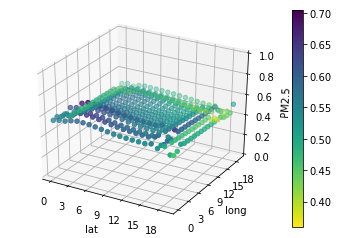

In [118]:
fig = plt.figure()
x = y = np.arange(0, 20, 1)
X, Y = np.meshgrid(x, y)
print(X.shape)
print(Y.shape)
#color = data.flatten()
color = ave.flatten()

ax = fig.add_subplot(1,1,1, projection='3d')
scat = ax.scatter(X, Y, ave,c=color, cmap="viridis_r")
ax.set_xlabel('lat')
ax.set_ylabel('long')
ax.set_zlabel('PM2.5')
ax.set_zlim(0, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.colorbar(scat)
#plt.savefig("originalPM_1.pdf")

(20, 20)
(20, 20)


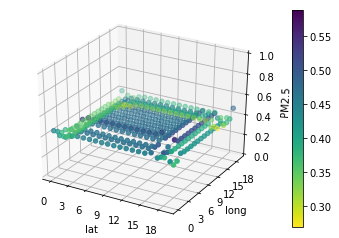

In [119]:
x = y = np.arange(0, 20, 1)
X, Y = np.meshgrid(x, y)
print(X.shape)
print(Y.shape)
color = d1.flatten()
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
scat = ax.scatter(X, Y, d1,c=color, cmap="viridis_r")
ax.set_xlabel('lat')
ax.set_ylabel('long')
ax.set_zlabel('PM2.5')
ax.set_zlim(0, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.colorbar(scat)
#plt.savefig("GANs_gen_1.pdf")

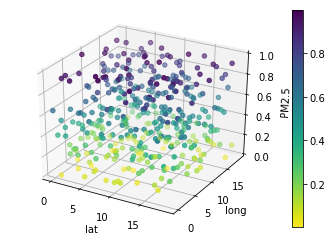

In [39]:
d2 = np.random.random((20,20))
color = d2.flatten()
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
scat = ax.scatter(X, Y, d2,c=color, cmap="viridis_r")
ax.set_xlabel('lat')
ax.set_ylabel('long')
ax.set_zlabel('PM2.5')
ax.set_zlim(0, 1)
plt.colorbar(scat)
#plt.savefig("Random_gen.pdf")